# Time Series approach

In [2]:
import os
import sys
import numpy as np
import scipy
import pandas as pd
import pywt 
import matplotlib.pyplot as plt
# For lag plot
from pandas.plotting import lag_plot
# For ACF
import statsmodels
from statsmodels.tsa.stattools import acf
# For zoom-in inside the plot box
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
# Gridspec
import matplotlib.gridspec as gridspec
# Vaex for lightweight plotting
import vaex as vx
# Gaussian Process
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel, WhiteKernel)
%matplotlib notebook

In [3]:
try:
    import gatspy
except:
    !{sys.executable} -m pip install gatspy --user
    # !conda install --yes --prefix {sys.prefix} gatspy

### Importing data, using Kepler light curves

Import a random Kepler light curve. Time is in days, flux is a relative scale.

In [4]:
fname = 'DataV_koi_kplr005706966.csv'

In [5]:
lc_x = pd.read_csv(fname, names=['time', 'flux', 'e_flux'], 
                   nrows=15000, engine='python')
npt_lsst = np.ceil(np.ptp(lc_x.time.values) / 1.6).astype('int')
lc_x2 = lc_x[::npt_lsst]
lc_x2.reset_index(drop=True, inplace=True)

Getting the sampling rate (cadence), we will need it after to scale measurements to day scales

In [6]:
cad1 = np.median(np.ediff1d(lc_x['time'].values))
cad2 = np.median(np.ediff1d(lc_x2['time'].values))
print('Kepler sampling: {0:.2f} d, LSST-like sampling:{1:.2f} d'.format(cad1, cad2))

Kepler sampling: 0.02 d, LSST-like sampling:4.33 d


Quick visualization, both Kepler sample-like and LSST sample-like (best scenario)

<IPython.core.display.Javascript object>


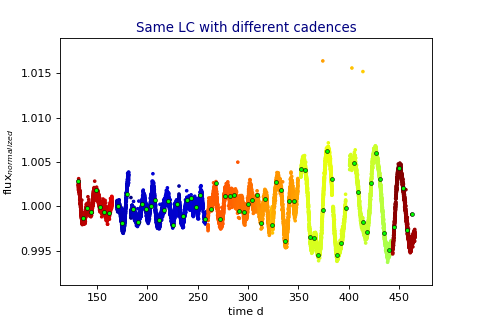

Text(0.5,1,'Same LC with different cadences')

In [7]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(lc_x.time, lc_x.flux, marker='o', s=5, c=lc_x.e_flux, cmap='jet')
ax.scatter(lc_x2.time, lc_x2.flux, marker='.', s=50, c='lime', edgecolor='k', lw=0.5)
ax.set_xlabel('time d')
ax.set_ylabel(r'flux$_{normalized}$')
ax.set_ylim([np.min(lc_x.flux) - np.std(lc_x.flux), np.max(lc_x.flux) + np.std(lc_x.flux)])
ax.set_title('Same LC with different cadences', color='navy')

### Import light curves into vaex

In [8]:
# Whole set
ds_all = vx.from_ascii(fname, seperator=",", names=['time', 'flux', 'e_flux'])

In [9]:
ds_K = vx.from_pandas(lc_x, name='kplr')
ds_L = vx.from_pandas(lc_x2, name='lsst')

<IPython.core.display.Javascript object>


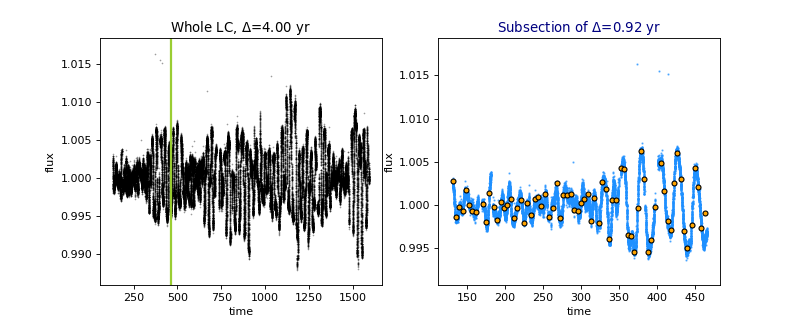

[ 131.51244013  465.7635854 ]


In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# Set first subplot as active 
plt.sca(ax[0])
ds_all.scatter('time', 'flux', c='k', alpha=0.6, s=0.1, length_limit=len(ds_all))
delta_yr = np.ptp(ds_all.minmax('time')) / 365
ax[0].set_title(r'Whole LC, $\Delta$={0:.2f} yr'.format(delta_yr))
ax[0].axvline(ds_K.max('time'), color='yellowgreen', lw=2)
# Now second plot
plt.sca(ax[1])
ds_K.scatter('time', 'flux', c='dodgerblue', alpha=0.6, s=1)
ds_L.scatter('time', 'flux', c='orange', alpha=1, s=20, edgecolor='k')
delta_yr = np.ptp(ds_K.minmax('time')) / 365
ax[1].set_title(r'Subsection of $\Delta$={0:.2f} yr'.format(delta_yr), color='navy')
print(ds_K.minmax('time'))

Quick checking: lag plot should be random for structures with no memory. The correlation here is a sanity check

<IPython.core.display.Javascript object>


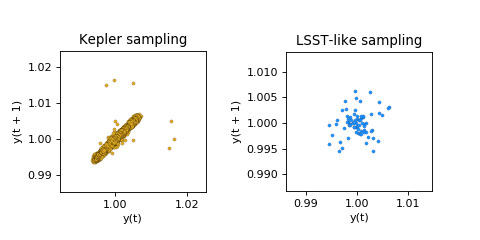

In [11]:
plt.close('all')
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
lag1 = lag_plot(lc_x.flux, ax=ax[0], marker='.', c='goldenrod', edgecolor='k', lw=0.1)
lag2 = lag_plot(lc_x2.flux, ax=ax[1], marker='.', c='dodgerblue', edgecolor='k', lw=0.1)
#
for sub in ax:
    sub.set_aspect('equal')
ax[0].set_title('Kepler sampling')
ax[1].set_title('LSST-like sampling')
plt.subplots_adjust(wspace=0.55)

## Autocorrelation Function 

$\rho_{k} = \dfrac{\sum_{i=0}^{N-k} x_{i}x_{i+k}}{\sum_{i}^{N} x_{i}}$
Where $\rho_{k}$ is the autocorrelation coefficient at lag *k*. Each lag *k* corresponds to $\tau_{k}=k\,\Delta t$, $\Delta t$ being the cadence.

It is safe to only look for periods shorter than half the light curve, $k \leq \frac{N}{2}$

Calculate the autocorrelation coefficients via statsmodels. Note that the `tsa.stattools.acf` method receives only the flux, thus assuming the spacing between each observation is uniform.

In [12]:
acf_coeffs = acf(lc_x.flux.values, unbiased=False, nlags=len(lc_x.flux.values) // 2)
tau_k = np.arange(1, acf_coeffs.size + 1, 1)
t_d = cad1 * tau_k 
#
print('Number of coefficients from the ACF calculation is: {0}'.format(acf_coeffs.size))

Number of coefficients from the ACF calculation is: 7501


<IPython.core.display.Javascript object>


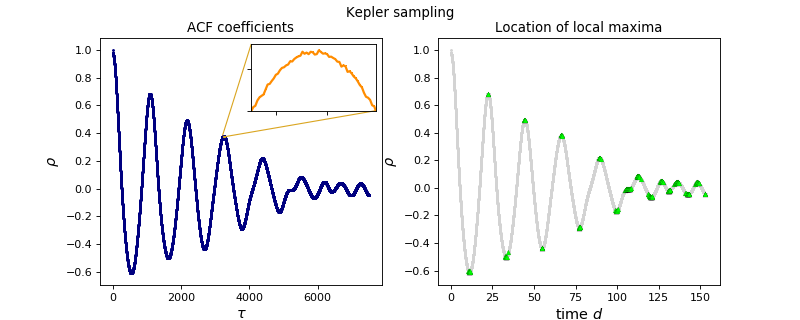

Text(0.5,0.98,'Kepler sampling')

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# Raw results from ACF are 'coarse', because of the nature of the input data
ax[0].scatter(tau_k, acf_coeffs, marker='.', s=10, color='navy')
# Zoom in
if 1:
    zoom_factor = 60
    ax0_zoom = zoomed_inset_axes(ax[0], zoom_factor, loc=1)
    # ax0_zoom.scatter(tau_k, acf_coeffs, marker='.', s=20, color='darkorange')
    ax0_zoom.plot(tau_k, acf_coeffs, ',-', lw=2, color='darkorange')
    ax0_zoom.set_xlim(3213, 3274)
    ax0_zoom.set_ylim(0.375, 0.383)
    ## Remove tick labels
    ax0_zoom.xaxis.set_major_formatter(plt.NullFormatter())
    ax0_zoom.yaxis.set_major_formatter(plt.NullFormatter())
    mark_inset(ax[0], ax0_zoom, loc1=2, loc2=4, fc='none', ec='goldenrod')
#
# Maxima for the coefficients
aux_maxima = scipy.signal.argrelextrema(acf_coeffs, np.greater)
ax[1].scatter(t_d, acf_coeffs, marker='.', s=10, color='lightgray')
ax[1].scatter(t_d[aux_maxima], acf_coeffs[aux_maxima], marker='^', s=20, color='lime', 
              edgecolor='k', linewidths=0.1)
#
for axis in ax:
    axis.set_ylabel(r'$\rho$', fontsize=13)
ax[0].set_xlabel(r'$\tau$', fontsize=13)
ax[1].set_xlabel(r'time $d$', fontsize=13)
#
ax[0].set_title('ACF coefficients')
ax[1].set_title('Location of local maxima')
plt.suptitle('Kepler sampling')

**Smooth the ACF coefficient distribution to easyly locate the local maxima. **

In [14]:
def gaussian(mu, sigma, x):
    return np.exp(np.power(-(x - mu), 2) / (2 * np.power(sigma, 2))) / (sigma * np.sqrt(2 * np.pi))

Values for the Gaussian (convolution) are empirical, as a compromise between diminish noise and keep the ACF signal. 
Note we need to trim a bit the result array, due to border padding. Also, remember the normalization, to keep the scale.

A suggestion from literature (McQuillan + 2013):
```
sigma_x = 18 / 2.35
x = np.arange(0, 56, 1)
```

In [15]:
sigma_x = 18 / 2.35
x = np.arange(0, 56, 1)
acf_g_conv = scipy.signal.convolve(acf_coeffs, gaussian(0, sigma_x, x)) / np.sum(gaussian(0, sigma_x, x))
print('Original size of the ACF coefficients array: {0}. The smoothed: {1}'.format(acf_coeffs.size, acf_g_conv.size))

Original size of the ACF coefficients array: 7501. The smoothed: 7556


In [16]:
# Trim the padded extra section, and re-use the previously defined inteval tau_k
Ntrim = acf_g_conv.size - acf_coeffs.size
acf_g_conv = acf_g_conv[Ntrim:]

In [17]:
# Local maxima
aux_maxima = scipy.signal.argrelextrema(acf_g_conv, np.greater)
# Global maxima
idx_gmax = np.argmax(acf_g_conv[aux_maxima])

<IPython.core.display.Javascript object>


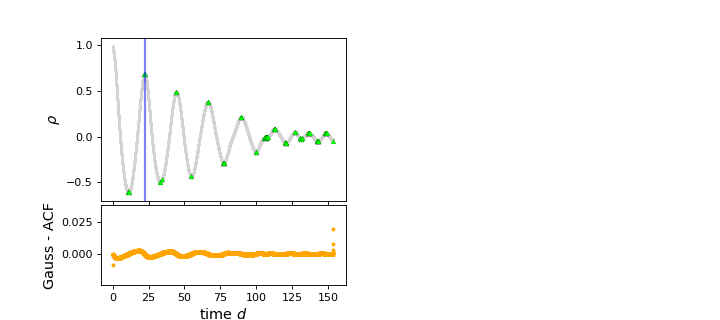

Text(0,0.5,'Gauss - ACF')

In [18]:
# Grid
fig = plt.figure(figsize=(9, 4))
gs1 = gridspec.GridSpec(3, 3)
gs1.update(left=0.14, right=0.48, hspace=0.05)
ax0 = fig.add_subplot(gs1[: -1, :])
ax1 = fig.add_subplot(gs1[-1, :], sharex=ax0)
#
ax1.scatter(t_d, acf_g_conv - acf_coeffs, marker='*', s=10, color='orange')
# 
ax0.scatter(t_d, acf_g_conv, marker='.', s=10, color='lightgray')
ax0.scatter(t_d[aux_maxima], acf_g_conv[aux_maxima], marker='^', s=20, color='lime', 
              edgecolor='k', linewidths=0.1)
# 
ax0.axvline(t_d[aux_maxima][idx_gmax], lw=2, c='b', alpha=0.5)
#
ax0.set_ylabel(r'$\rho$', fontsize=13)
ax1.set_xlabel(r'time $d$', fontsize=13)
ax1.set_ylabel(r'Gauss - ACF', fontsize=13)

In [25]:
max_acf_kplr = t_d[aux_maxima][np.argmax(acf_g_conv[aux_maxima])]

In [26]:
print('Maximum of the ACF: {0:.2f} d'.format(max_acf_kplr))

Maximum of the ACF: 22.25 d


### Let's do the same for the more sparse situation...

In [19]:
acf_coeffs_spa = acf(lc_x2.flux.values, unbiased=False, nlags=len(lc_x2.flux.values) // 2)
tau_k_spa = np.arange(1, acf_coeffs_spa.size + 1, 1)
t_d_spa = cad2 * tau_k_spa

We must remember that so far we are assuming an uniform sampling . In the case of Kepler cadence, given the amount of points, for this analysis this is not a concern.

In the case of a more sparse time series, changes in the cadence will make us result not be as accurate as if having a regular cadence.

<IPython.core.display.Javascript object>


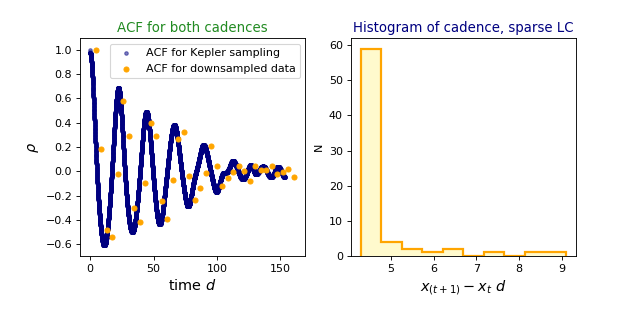

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(t_d, acf_coeffs, alpha=0.5, label='ACF for Kepler sampling', c='navy', s=10)
ax[0].scatter(t_d_spa, acf_coeffs_spa, label='ACF for downsampled data', c='orange', s=20)
# Histogram of the cadence in the data
ax[1].hist(np.ediff1d(lc_x2['time'].values), bins=10, histtype='stepfilled', color=['lemonchiffon'], lw=0)
ax[1].hist(np.ediff1d(lc_x2['time'].values), bins=10, histtype='step', color=['orange'], lw=2)
#
ax[0].legend(loc='upper right')
ax[0].set_xlabel(r'time $d$', fontsize=13)
ax[0].set_ylabel(r'$\rho$', fontsize=13)
ax[1].set_xlabel(r'$x_{(t+1)}-x_{t}$ $d$', fontsize=13)
ax[1].set_ylabel('N')
ax[0].set_title('ACF for both cadences', color='forestgreen')
ax[1].set_title('Histogram of cadence, sparse LC', color='navy')
#
plt.subplots_adjust(bottom=0.2)

In [22]:
# Local maxima
aux_maxima_spa = scipy.signal.argrelextrema(acf_coeffs_spa, np.greater)
# Global maxima
idx_gmax = np.argmax(acf_coeffs_spa[aux_maxima_spa])

In [23]:
max_acf_lsst = t_d_spa[aux_maxima_spa][np.argmax(acf_coeffs_spa[aux_maxima_spa])]

In [27]:
txt = 'Maximum of the ACF, for sparse scenario: {0:.2f} d, this represents a variation'.format(max_acf_lsst)
txt +=  ' of {0:.2f}% respect to Kepler-sampling'.format(max_acf_lsst * 100 / max_acf_kplr - 100)
print(txt)

Maximum of the ACF, for sparse scenario: 25.99 d, this represents a variation of 16.80% respect to Kepler-sampling


A variation of 17% maybe is within our scientific expectatins, maybe not. Let's try a method to fill gaps, for the case when we miss some observatins, or need more points.
Note that a previous knowledge of the expected behaviour increases our chances of get a more accurate prediction.

### Gap filling

Fillig the gaps will allow us to have a more regular sampled grid. In the case when fewer observations are available, compared with the main variability length, to have an uniform sampling makes calculations more stable.

**Important**: *chains of N >= 4000 and long runs, make your regression more robust. Let it run long enough!*

In [28]:
# Instance of the GP
guess_period = max_acf_kplr
# length_scale: while larger, the shapes of the samples elongate. Default:1.
# length_scale_bounds: lower and upper bounds for lenght_scale. Let's say is a day
# periodicity_bounds: lower and upper bounds in periodicity
if 0:
    kernel = 1.0 * ExpSineSquared(length_scale=guess_period/2., 
                                  periodicity=guess_period,
                                  length_scale_bounds=(guess_period, 1.1*guess_period),
                                  periodicity_bounds=(guess_period/2, 1.5 * guess_period),
                                 )
else:
    # Exponential Sine
    expsine= 1. * ExpSineSquared(length_scale=guess_period / 2., 
                                  periodicity=guess_period,
                                  length_scale_bounds=(guess_period, 1.1*guess_period),
                                  periodicity_bounds=(guess_period/2, 1.5 * guess_period),)
    # Radial Basis Function
    rbf = 1.0 * RBF(length_scale=2 * guess_period, 
                    length_scale_bounds=(0.1 * guess_period, 4.0 * guess_period))
    # Rational Quadratic
    rquad =  1. * RationalQuadratic(length_scale=np.ptp(lc_x2.time.values) / 10, 
                                    alpha=1)
    # Matern (unstable in this scenario)
    matern = .5 * Matern(length_scale= 2 * guess_period, 
                         length_scale_bounds=(0.5 * guess_period, 10 *guess_period), 
                         nu=1.5)
    kernel = expsine + rbf
# If want to replicate the result, must use same seed 
aux_seed = np.random # 45
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, random_state=aux_seed)
if 1:
    # Calculate the prior
    x_prior = np.linspace(lc_x2.time.values[0], lc_x2.time.values[-1], 1000)
    y_mean_prior, y_std_prior = gp.predict(x_prior[:, np.newaxis], return_std=True)
    y_samples_prior = gp.sample_y(x_prior[:, np.newaxis], 1000)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(lc_x2.time.values[:, np.newaxis], lc_x2.flux.values)
# Posterior
x_grid = np.linspace(lc_x2.time.values[0], lc_x2.time.values[-1], 1000)
# Make the prediction on the meshed x-axis (ask for MSE as well)
y_mean_post, y_std_post = gp.predict(x_grid[:, np.newaxis], return_std=True)
y_samples_post = gp.sample_y(x_grid[:, np.newaxis], 5000)

/Users/fco/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


<IPython.core.display.Javascript object>


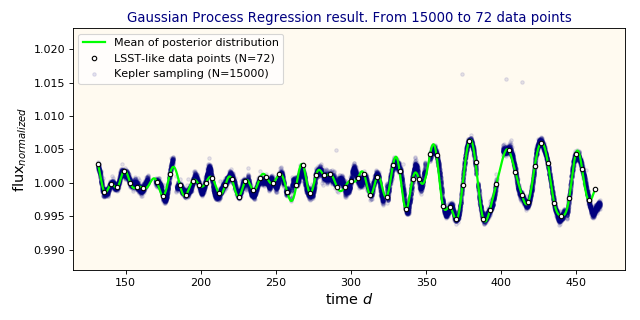

In [31]:
fig, ax = plt.subplots(1, figsize=(8, 4))
# Vaex for the Kepler sampling
ds_K.scatter('time', 'flux', label=
             'Kepler sampling (N={0})'.format(len(ds_K)), 
             c='navy', alpha=0.1, s=10)
# Posterior <x>
ax.plot(x_grid, y_mean_post, lw=2, c='lime', label='Mean of posterior distribution')
# Initial data points
ax.plot(lc_x2.time, lc_x2.flux, 'o', c='w', 
        label='LSST-like data points (N={0})'.format(len(lc_x2.index)), 
        markersize=4, markeredgecolor='k')
#
ax.set_title('Gaussian Process Regression result. From 15000 to 72 data points', color='navy')
ax.set_xlabel(r'time $d$', fontsize=13)
ax.set_ylabel(r'flux$_{normalized}$', fontsize=13)
plt.tight_layout()
ax.set_facecolor('floralwhite')
ax.legend(loc='upper left')

In [62]:
t = 'Posterior\n{0}\nkernel =  {1}'.format('=' * len('Posterior'),gp.kernel_)
t += '\nLog-likelohood ={0:.3f}'.format(gp.log_marginal_likelihood(gp.kernel_.theta))
print(t)

Posterior
kernel =  0.609**2 * ExpSineSquared(length_scale=24.5, periodicity=24.7) + 0.00316**2 * RBF(length_scale=3.86)
Log-likelohood =323.334


**Note through the iterations the periodicity value was changed.**

In [32]:
if False:
    import pickle
    pickle.dump(y_mean_post, open('y_mean_posterior_lsst.pickle', 'wb'))
    np.save('y_mean_posterior.npy', y_mean_post)

## Cross Validation

Note we trained the Gaussian Process and tested/applied it on the same dataset. In this scenario the model would probably fail to  predict unknown data. Then, we should have different subsets of data on which train and evaluate teh data.

What are this sets?
- train set: on which the training proceeds
- validation set: after the training, evaluation of trained model is made on the validation set
- test set: final evaluation of the model, when all looks good

The problem is... many times we don't have so much data to chunk into pieces. With small *N* we coud easily fall in a strong dependece of the selection of such subsets. Here is when Cross Validation comes to save us: it uses a subsample for training and then evaluate the model on the remaining data, by *folds*. 

In [49]:
from sklearn.cross_validation import cross_val_score, KFold
# 1) Instance the GP
# Exponential Sine
expsine= 1. * ExpSineSquared(length_scale=guess_period / 2., 
                              periodicity=guess_period,
                              length_scale_bounds=(guess_period, 1.1*guess_period),
                              periodicity_bounds=(guess_period/2, 1.5 * guess_period),)
# Radial Basis Function
rbf = 1.0 * RBF(length_scale=2 * guess_period, 
                length_scale_bounds=(0.1 * guess_period, 4.0 * guess_period))
#
kernel = expsine + rbf
aux_seed = np.random 
gaussian_pr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, random_state=aux_seed)
# 2) Fit the model, using the maximization of the likelihood
gaussian_pr.fit(lc_x2.time.values[:, np.newaxis], lc_x2.flux.values)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * ExpSineSquared(length_scale=11.1, periodicity=22.3) + 1**2 * RBF(length_scale=44.5),
             n_restarts_optimizer=50, normalize_y=False,
             optimizer='fmin_l_bfgs_b',
             random_state=<module 'numpy.random' from '/Users/fco/anaconda3/lib/python3.6/site-packages/numpy/random/__init__.py'>)

In [98]:
# Define the Cross validation
from sklearn.model_selection import GridSearchCV
gpr_grid = {
    'kernel' : [expsine + rbf]}
n_kfolds = 5
CV = GridSearchCV(estimator=GaussianProcessRegressor(), 
                  param_grid=gpr_grid,
                  n_jobs=2, 
                  cv=n_kfolds,
                  refit=True, 
                 )

In [99]:
# Fit
CV.fit(lc_x2.time.values[:, np.newaxis], lc_x2.flux.values)

GridSearchCV(cv=5, error_score='raise',
       estimator=GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'kernel': [1**2 * ExpSineSquared(length_scale=11.1, periodicity=22.3) + 1**2 * RBF(length_scale=44.5)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [100]:
# Get the prediction, note the "phantom dimension"
x_cv = np.linspace(lc_x2.time.values[0], lc_x2.time.values[-1], 1000)[:, None]
y_cv = CV.predict(x_cv)

<IPython.core.display.Javascript object>


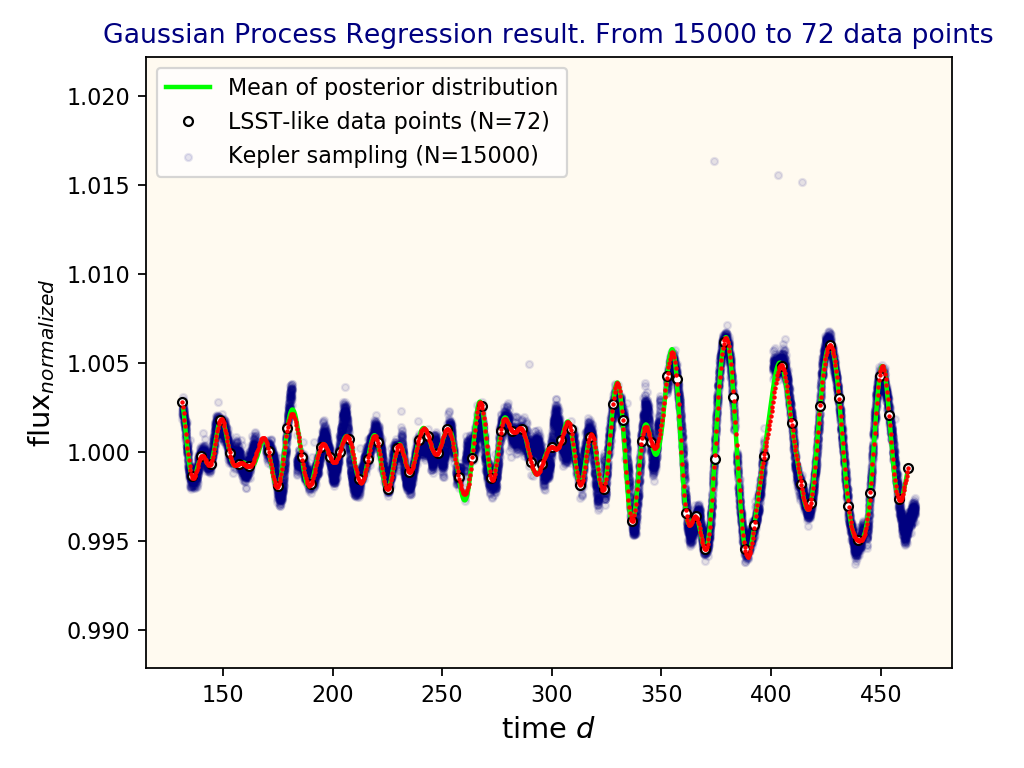

In [103]:
fig, ax = plt.subplots()
# Vaex for the Kepler sampling
ds_K.scatter('time', 'flux', label=
             'Kepler sampling (N={0})'.format(len(ds_K)), 
             c='navy', alpha=0.1, s=10)
# Posterior <x>
ax.plot(x_grid, y_mean_post, lw=2, c='lime', label='Mean of posterior distribution')
# Initial data points
ax.plot(lc_x2.time, lc_x2.flux, 'o', c='w', 
        label='LSST-like data points (N={0})'.format(len(lc_x2.index)), 
        markersize=4, markeredgecolor='k')
# CV
ax.plot(x_cv, y_cv, 'ro', markersize=1)
#
ax.set_title('Gaussian Process Regression result. From 15000 to 72 data points', color='navy')
ax.set_xlabel(r'time $d$', fontsize=13)
ax.set_ylabel(r'flux$_{normalized}$', fontsize=13)
plt.tight_layout()
ax.set_facecolor('floralwhite')
ax.legend(loc='upper left')

In [ ]:
# Abreviated 
# Try it when the whole method is complete
from sklearn.pipeline import make_pipeline
clf = make_pipeline(preprocessing.StandardScaler(), svm.SVC(C=1))
cross_val_score(clf, iris.data, iris.target, cv=cv)

## Lomb Scargle

Different modules available! **gatpsy**, **astropy**, **astroML**... and the less fancy **scipy**

#### Starting with Fast LS

In [33]:
m_fls = gatspy.periodic.LombScargleFast(fit_period=True)

In [34]:
m_fls.optimizer.period_range = (1, 100)

In [35]:
m_fls.fit(lc_x.time.values, lc_x.flux.values, lc_x.e_flux.values)

Finding optimal frequency:
 - Estimated peak width = 0.0188
 - Using 5 steps per peak; omega_step = 0.00376
 - User-specified period range:  1 to 1e+02
 - Computing periods at 1656 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


First do the search on the coarse grid of frequencies, and then on a second step on a more fine grid

In [36]:
fls_period = m_fls.best_period

To plot the periodogram

In [37]:
periods = np.linspace(1, 100, 1000)
scores = m_fls.score(periods)

/Users/fco/anaconda3/lib/python3.6/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "


<IPython.core.display.Javascript object>


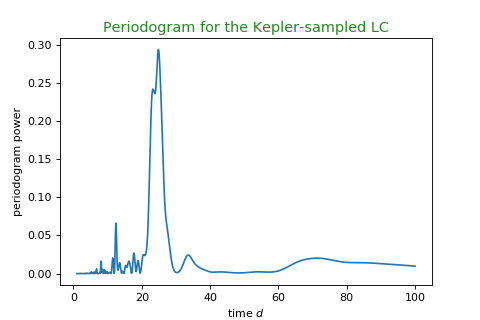

Text(0.5,1,'Periodogram for the Kepler-sampled LC')

In [40]:
fig, ax = plt.subplots(1, figsize=(6, 4))
ax.plot(periods, scores)
ax.set_xlabel(r'time $d$')
ax.set_ylabel(r'periodogram power')
ax.set_title('Periodogram for the Kepler-sampled LC', fontsize=13, color='forestgreen')

Phase diagram

1) fill an auxiliary array for the predicted shape in the phase diagram. A better fit would be using the first 4 more prominent periods

2) chunk time vector to fit in the phase plot

3) plot all together

In [41]:
aux_time = np.linspace(0, fls_period, 1000)
flux_fit = m_fls.predict(aux_time)

In [42]:
phase = (lc_x.time.values / fls_period) % 1
phasefit = (aux_time / fls_period)

In [43]:
ds_K_phase = vx.from_arrays(phase=phase, flux=lc_x.flux.values)

<IPython.core.display.Javascript object>


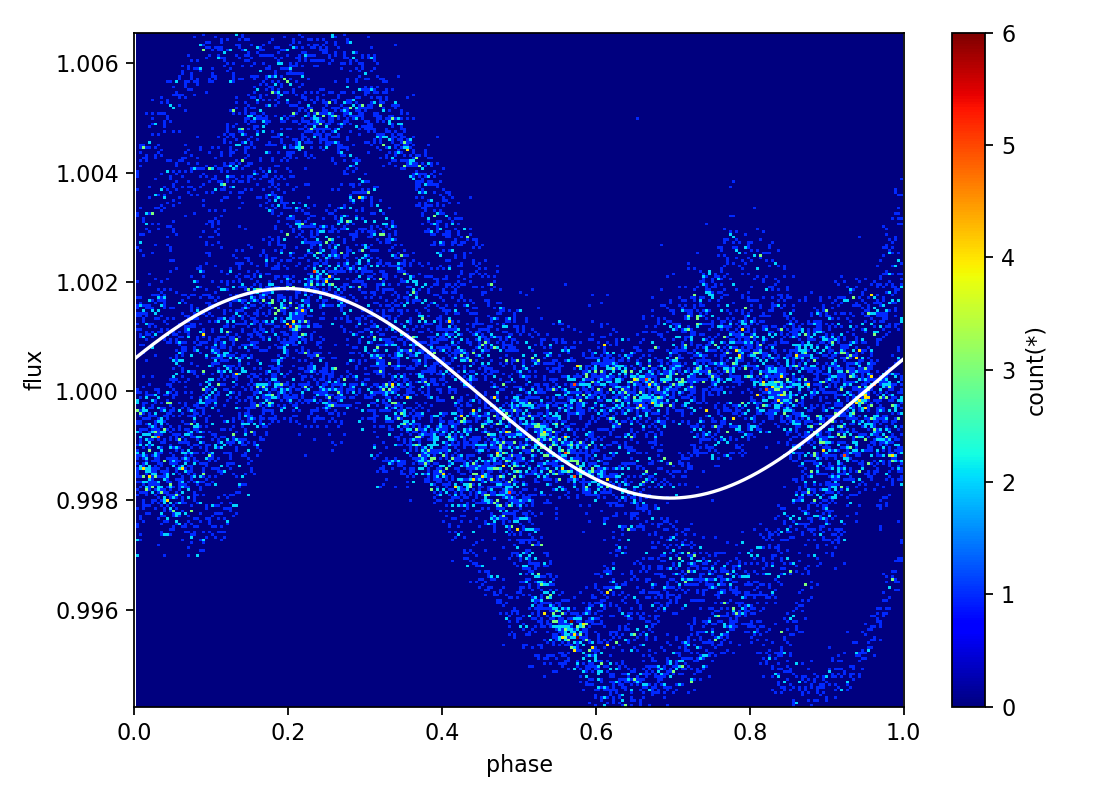

(0, 1)

In [171]:
fig, ax = plt.subplots(1, figsize=(7, 5))
plt.sca(ax)
kw = {
    'vmin' : 1,
    'colormap' : 'jet',
    'background_color' : 'white',
}
ds_K_phase.plot('phase', 'flux', **kw)
# ax[0].errorbar(phase, lc_x.flux.values, lc_x.e_flux.values, fmt='o')
ax.plot(phasefit, flux_fit, '-', color='w')
ax.set_xlim([0, 1])
ax.set_title()

If we want to refine the period estimation

In [178]:
m2_fls = gatspy.periodic.LombScargleFast(fit_period=True)
m2_fls.optimizer.set(period_range=(0.5 * fls_period, 2 * fls_period), first_pass_coverage=10)
m2_fls.fit(lc_x.time.values, lc_x.flux.values, lc_x.e_flux.values)
aux2_fls_period = m2_fls.best_period

Finding optimal frequency:
 - Estimated peak width = 0.0188
 - Using 10 steps per peak; omega_step = 0.00188
 - User-specified period range:  12 to 50
 - Computing periods at 203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 495 steps


In [179]:
print('Optimized period: {0:.2f} d is {1} times the initial evaluation'.format(aux2_fls_period, 
                                                                               aux2_fls_period / fls_period))

Optimized period: 24.73 d is 0.9943960609214841 times the initial evaluation


For noisy light curves, a second optimization would be of special interest

#### Now let's go to the traditional LS, to get the period of the sparse case

Initialize the Lomb Scargle estimator

In [226]:
m_genls4 = gatspy.periodic.LombScargle(Nterms=3, 
                                       fit_period=True)
m_genls1 = gatspy.periodic.LombScargle(Nterms=1, 
                                       fit_period=True)
m_genls4.optimizer.period_range = (1, 100)
m_genls1.optimizer.period_range = (1, 100)

Fit LS using the observed data

In [227]:
m_genls4.fit(lc_x2.time.values, lc_x2.flux.values)
m_genls1.fit(lc_x2.time.values, lc_x2.flux.values)

Finding optimal frequency:
 - Estimated peak width = 0.019
 - Using 5 steps per peak; omega_step = 0.0038
 - User-specified period range:  1 to 1e+02
 - Computing periods at 1640 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.019
 - Using 5 steps per peak; omega_step = 0.0038
 - User-specified period range:  1 to 1e+02
 - Computing periods at 1640 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Get best periods

In [228]:
genls4_periods = m_genls4.find_best_periods()
genls1_periods = m_genls1.find_best_periods()

Finding optimal frequency:
 - Estimated peak width = 0.019
 - Using 5 steps per peak; omega_step = 0.0038
 - User-specified period range:  1 to 1e+02
 - Computing periods at 1640 steps
Zooming-in on 10 candidate peaks:
 - Computing periods at 1990 steps
Finding optimal frequency:
 - Estimated peak width = 0.019
 - Using 5 steps per peak; omega_step = 0.0038
 - User-specified period range:  1 to 1e+02
 - Computing periods at 1640 steps
Zooming-in on 10 candidate peaks:
 - Computing periods at 1990 steps


In [247]:
genls4_periods, genls1_periods

(array([ 24.68342644,  11.09965571,  74.7144516 ,   2.05942885,  49.71015437]),
 array([ 24.89884963,   1.02956517,  23.05338646,   3.70314825,   1.51159085]))

Periodograms, internally calculating the frequency spacing

In [232]:
genls4_per = m_genls4.periodogram_auto()
genls1_per = m_genls1.periodogram_auto()

<IPython.core.display.Javascript object>


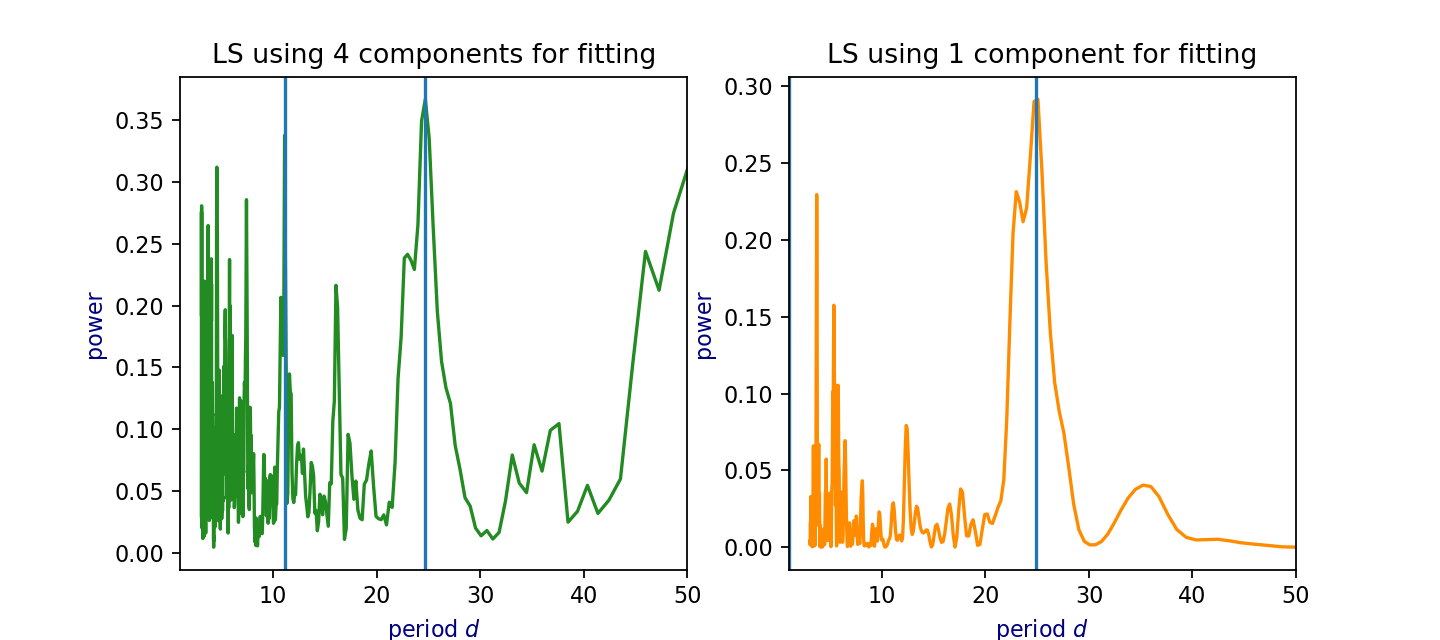

Text(0.5,1,'LS using 1 component for fitting')

In [251]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].plot(genls4_per[0], genls4_per[1], ls='-', color='forestgreen')
ax[1].plot(genls1_per[0], genls1_per[1], ls='-', color='darkorange')
# Mark most prominent periods
for p in range(len(genls4_per)):
    ax[0].axvline(genls4_periods[p])
    ax[1].axvline(genls1_periods[p])
# Axis minimal setup
for subp in ax:
    subp.set_xlim([1, 50])
    subp.set_xlabel(r'period $d$', color='navy')
    subp.set_ylabel(r'power', color='navy')
ax[0].set_title('LS using 4 components for fitting')
ax[1].set_title('LS using 1 component for fitting')


### Wavelet Transform

In [101]:
# https://github.com/PyWavelets/pywt/blob/master/demo/cwt_analysis.py
# http://nicolasfauchereau.github.io/climatecode/posts/wavelet-analysis-in-python/

In [1]:
# Start from scratch with thi example: https://github.com/PyWavelets/pywt/blob/master/demo/cwt_analysis.py

<IPython.core.display.Javascript object>


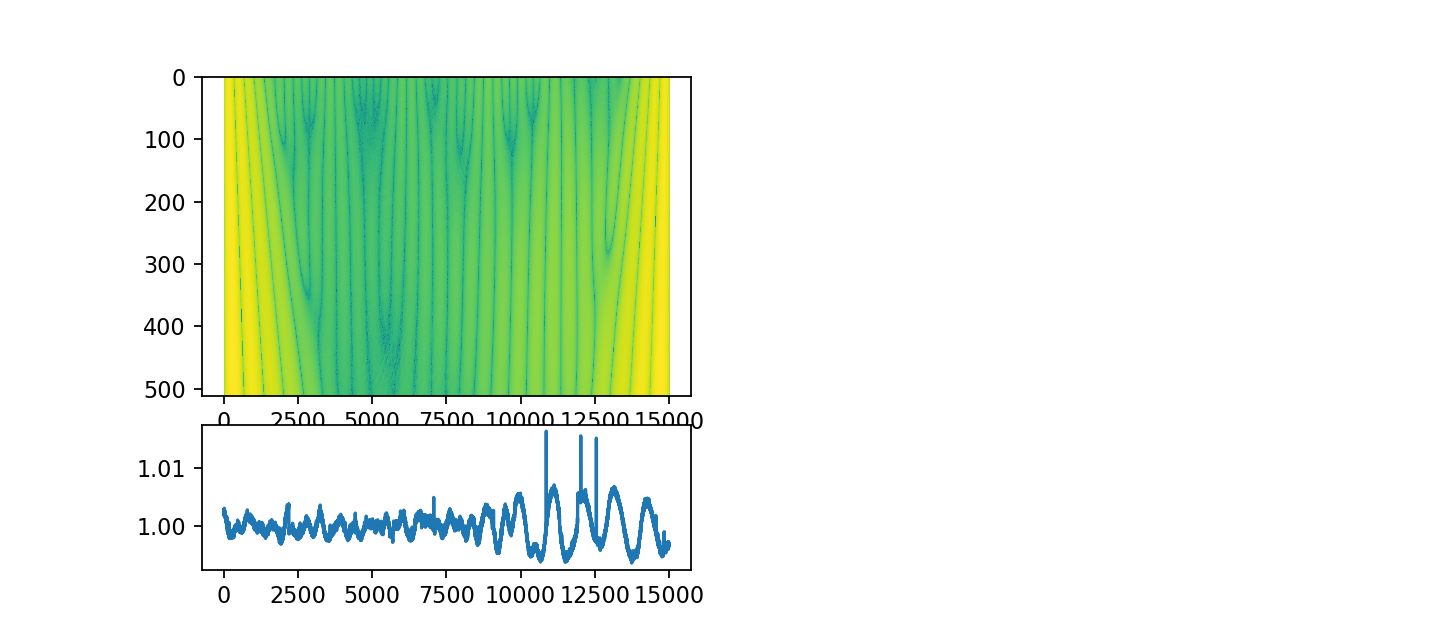

[ 12.87695439  12.90210469  12.92725499  12.95240529  12.97755559
  13.0027059   13.0278562   13.0530065   13.0781568   13.1033071
  13.1284574   13.1536077   13.17875801  13.20390831  13.22905861
  13.25420891  13.27935921  13.30450951  13.32965982  13.35481012
  13.37996042  13.40511072  13.43026102  13.45541132  13.48056162
  13.50571193  13.53086223  13.55601253  13.58116283  13.60631313
  13.63146343  13.65661374  13.68176404  13.70691434  13.73206464
  13.75721494  13.78236524  13.80751554  13.83266585  13.85781615
  13.88296645  13.90811675  13.93326705  13.95841735  13.98356766
  14.00871796  14.03386826  14.05901856  14.08416886  14.10931916
  14.13446946  14.15961977  14.18477007  14.20992037  14.23507067
  14.26022097  14.28537127  14.31052158  14.33567188  14.36082218
  14.38597248  14.41112278  14.43627308  14.46142338  14.48657369
  14.51172399  14.53687429  14.56202459  14.58717489  14.61232519
  14.6374755   14.6626258   14.6877761   14.7129264   14.7380767   14.763227


"\nax.contourf(time, np.log2(period), np.log2(power), np.log2(levels),\n            extend='both')\n\nax.set_ylabel('Period (years)')\nYticks = 2 ** np.arange(np.ceil(np.log2(period.min())),\n                        np.ceil(np.log2(period.max())))\nax.set_yticks(np.log2(Yticks))\nax.set_yticklabels(Yticks)\nax.invert_yaxis()\nylim = ax.get_ylim()\nax.set_ylim(ylim[0], -1)\n"

In [131]:
time, flux = lc_x.time.values, lc_x.flux.values

scales = np.arange(512, 1024)
m_wv = 'morl'#'dmey' #'morl'
[cfs, frequencies] = pywt.cwt(flux, scales, m_wv, time[1] - time[0])
power = np.power(abs(cfs), 2)
period = 1. / frequencies

fig = plt.figure(figsize=(9, 4))
gs1 = gridspec.GridSpec(3, 3)
gs1.update(left=0.14, right=0.48, hspace=0.2)
ax0 = fig.add_subplot(gs1[: -1, :])
ax1 = fig.add_subplot(gs1[-1, :], sharex=ax0)

#ax0.contourf(time, np.log2(period), np.log2(power), np.log2(levels),
#            extend='both')
im = ax0.imshow(np.log2(power), aspect='auto')
print(period)


#plt.colorbar(im)
ax1.plot(np.arange(0, time.size), flux)
'''
ax.contourf(time, np.log2(period), np.log2(power), np.log2(levels),
            extend='both')

ax.set_ylabel('Period (years)')
Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                        np.ceil(np.log2(period.max())))
ax.set_yticks(np.log2(Yticks))
ax.set_yticklabels(Yticks)
ax.invert_yaxis()
ylim = ax.get_ylim()
ax.set_ylim(ylim[0], -1)
'''

In [128]:
# SCIPY!
from scipy import signal
coeffs = signal.cwt(lc_x.flux.values, signal.morlet, np.linspace(512, 2048))
coeffs = coeffs * coeffs

/Users/fco/anaconda3/lib/python3.6/site-packages/scipy/signal/wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')


<IPython.core.display.Javascript object>


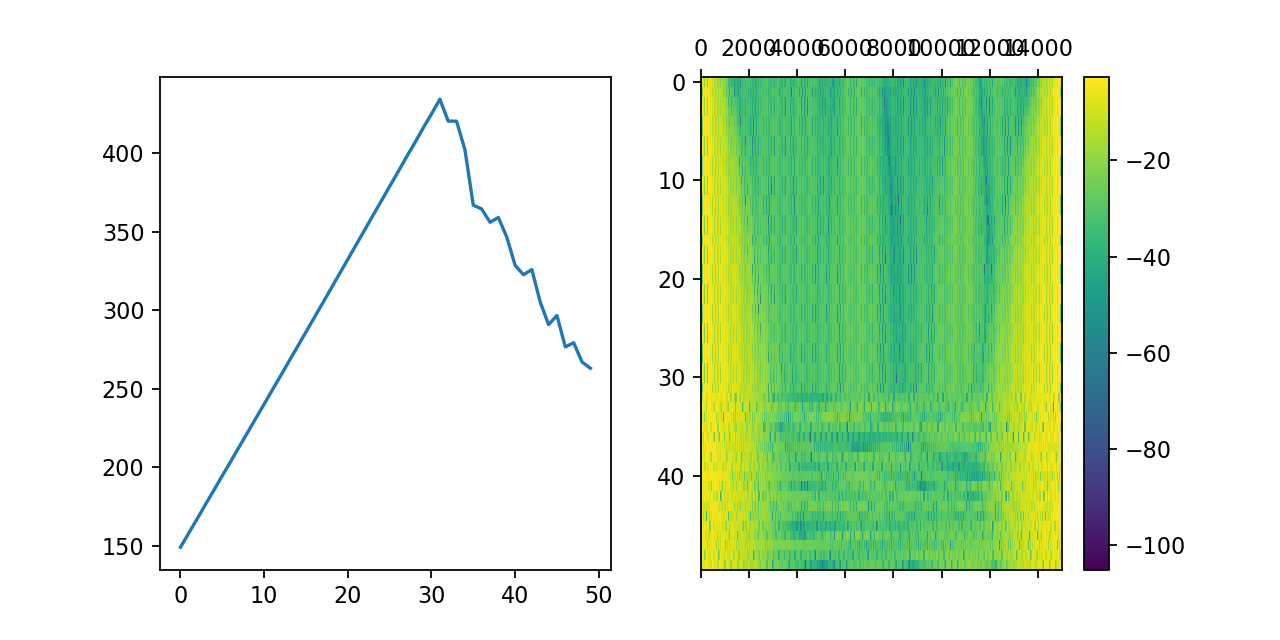

In [129]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
im = ax[1].matshow(np.log2(np.power(np.abs(coeffs), 2)), aspect='auto', cmap='viridis')
aux_sum = coeffs.sum(axis=1)
ax[0].plot(aux_sum)
plt.colorbar(im)